# Introduction

# Scope

# Performance metrics

# Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\time-series-stock-prices\\time-series-stock-prices'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

import config
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-muted')

# Data exploration

## Import data

In [2]:
stock_prices = pd.read_csv(config.file_directory('raw') + 'Nintendo.csv', parse_dates=['Date'])
stock_prices.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.200,4.275,4.05,4.200,3.990652,134500
1,2000-01-04,3.950,4.025,3.80,3.950,3.753113,171000
2,2000-01-05,3.875,3.900,3.70,3.875,3.681852,301500


## Data types

In [3]:
stock_prices.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

## Missing values

In [4]:
stock_prices.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Visualising the time series

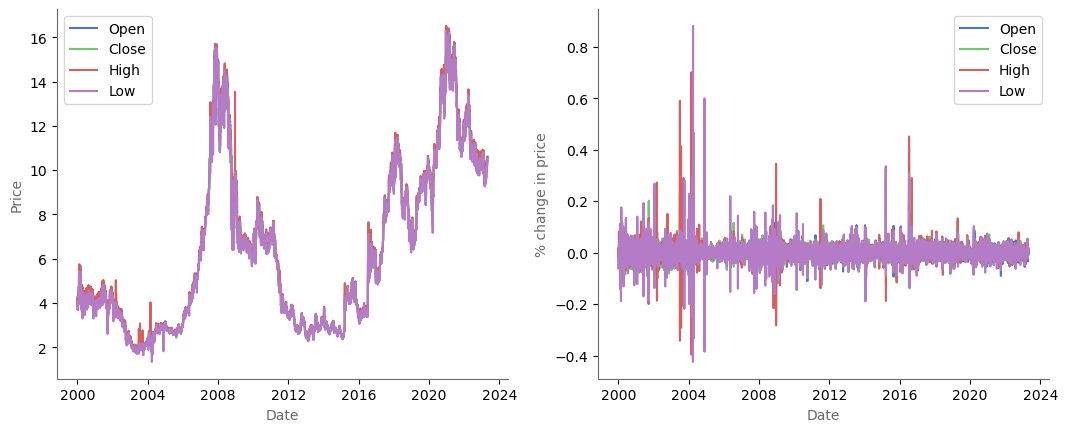

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))
for col in ['Open', 'Close', 'High', 'Low']:
    axes[0].plot(stock_prices['Date'], stock_prices[col], label=col);
    axes[1].plot(stock_prices['Date'], stock_prices[col].pct_change(), label=col);
    
for i, ax in enumerate(axes):
    if i==0:
        ax.set_ylabel('Price', color='dimgray');
    else:
        ax.set_ylabel('% change in price', color='dimgray');
    ax.set_xlabel('Date', color='dimgray');
    ax.spines[['top', 'right']].set_visible(False);
    ax.spines[['left', 'bottom']].set_color('dimgray');
    ax.legend();

### Autocorrelation

***Autocorrelation***
$$ r_k = \frac{\sum_{t=k+1}^T(y_t-\bar y)(y_{t-k}-\bar y)}{\sum_{t=1}^T(y_t-\bar y)^2}$$

Autocorrelation is the Pearson correlation between values as a function of the time lag *k*. It gives a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

***Partial autocorrelation***

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

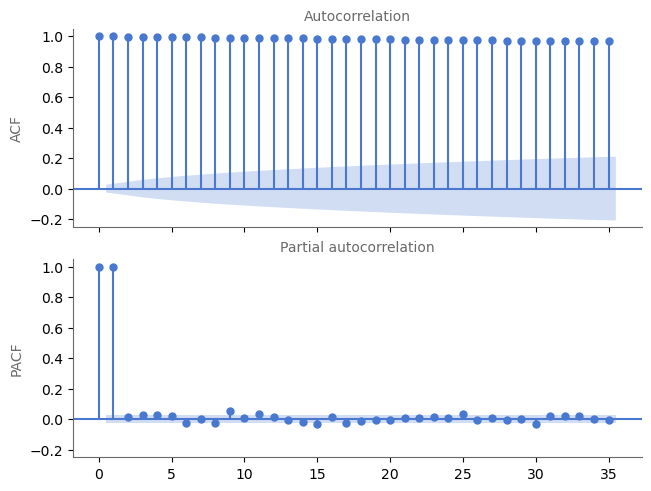

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

close_time_series = stock_prices[['Date', 'Close']].copy().set_index('Date')

fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)
plot_acf(close_time_series, lags=35, ax=axes[0]);
plot_pacf(close_time_series, lags=35, ax=axes[1]);
for i, ax in enumerate(axes):
    ax.set_ylim([-0.25, 1.05]);
    if i == 0:
        ax.set_ylabel('ACF', color='dimgray');
        ax.set_title('Autocorrelation', color='dimgray', size=10);
    else:
        ax.set_ylabel('PACF', color='dimgray');
        ax.set_title('Partial autocorrelation', color='dimgray', size=10);
    ax.spines[['top', 'right']].set_visible(False);
    ax.spines[['left', 'bottom']].set_color('dimgray');

### Stationarity

* A stationary time series is a time series that has no trend.
* A time series is said to be stationary if it has constant mean, variance and the covariance is independent of time.
* The *Dickey-Fuller test* is a statistical hypothesis test that allows you to detect non-stationarity. If the p-value is <=0.05 then we reject the null hypothesis as the data does not have a unit root and is stationary.

In [7]:
from statsmodels.tsa.stattools import adfuller

adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(close_time_series)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -1.4773931994063643
ADF p-values: 0.5446634922557888
ADF number of lags used: 16
ADF number of observations: 5851
ADF critical values: {'1%': -3.4314681287355286, '5%': -2.8620341078117546, '10%': -2.5670330114662234}
ADF best information criterion: -4133.668521892563


### Times series decomposition

$$ y_t=S_t + T_t + R_t $$
$$ y_t=S_t \times T_t \times R_t $$
<center> Where y<sub>t</sub> is the data, T<sub>t</sub> is the trend-cycle component and R<sub>t</sub> is the residual. </center>

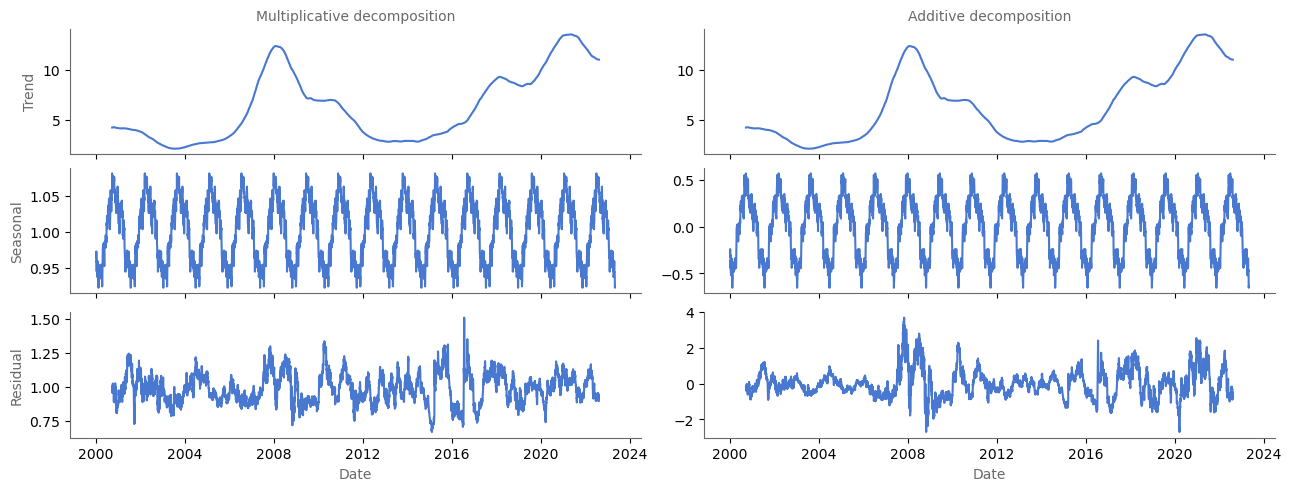

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_mul = seasonal_decompose(close_time_series, model='multiplicative', period=365)
decomp_add = seasonal_decompose(close_time_series, model='additive', period=365)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8))
axes[0, 0].plot(decomp_mul.trend);
axes[0, 1].plot(decomp_add.trend);
axes[1, 0].plot(decomp_mul.seasonal);
axes[1, 1].plot(decomp_add.seasonal);
axes[2, 0].plot(decomp_mul.resid);
axes[2, 1].plot(decomp_add.resid);
axes[0, 0].set_title('Multiplicative decomposition', color='dimgray', size=10);
axes[0, 1].set_title('Additive decomposition', color='dimgray', size=10);
axes[0, 0].set_ylabel('Trend', color='dimgray');
axes[1, 0].set_ylabel('Seasonal', color='dimgray');
axes[2, 0].set_ylabel('Residual', color='dimgray');
axes[2, 0].set_xlabel('Date', color='dimgray');
axes[2, 1].set_xlabel('Date', color='dimgray');

for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False);
    ax.spines[['left', 'bottom']].set_color('dimgray');

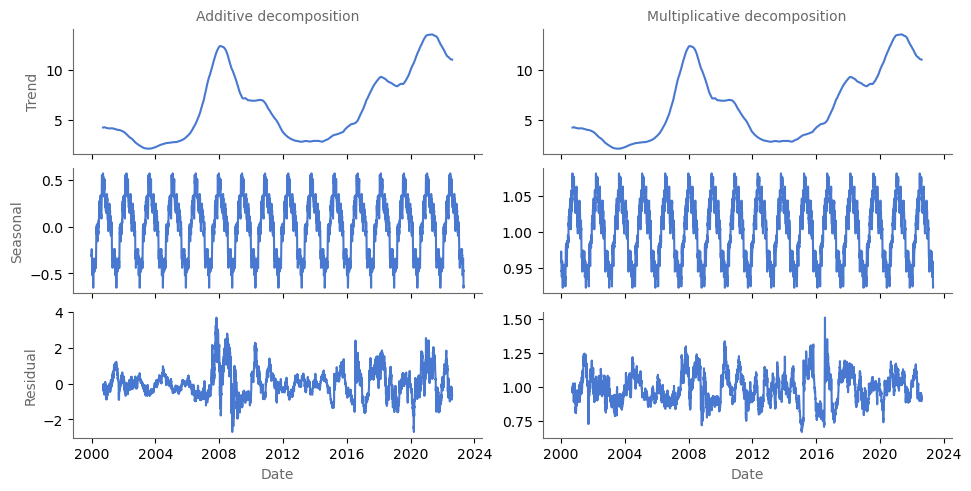

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

close_time_series = stock_prices[['Date', 'Close']].copy(deep=True).set_index('Date')
close_time_series = close_time_series.sort_index()
additive_decomp = seasonal_decompose(close_time_series, model = 'additive', period=365)
multiplicative_decomp = seasonal_decompose(close_time_series, model = 'multiplicative', period=365)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, constrained_layout=True, figsize=(6.4*1.5, 4.8));
axes[0, 0].plot(additive_decomp.trend);
axes[1, 0].plot(additive_decomp.seasonal);
axes[2, 0].plot(additive_decomp.resid);
axes[0, 1].plot(multiplicative_decomp.trend);
axes[1, 1].plot(multiplicative_decomp.seasonal);
axes[2, 1].plot(multiplicative_decomp.resid);

axes[0, 0].set_title('Additive decomposition', size=10, color='dimgray');
axes[0, 0].set_ylabel('Trend', color='dimgray');
axes[1, 0].set_ylabel('Seasonal', color='dimgray');
axes[2, 0].set_xlabel('Date', color='dimgray')
axes[2, 0].set_ylabel('Residual', color='dimgray');
axes[0, 1].set_title('Multiplicative decomposition', size=10, color='dimgray');
axes[2, 1].set_xlabel('Date', color='dimgray');

for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False);
    ax.spines[['left', 'bottom']].set_color('dimgray');

# Train/test split

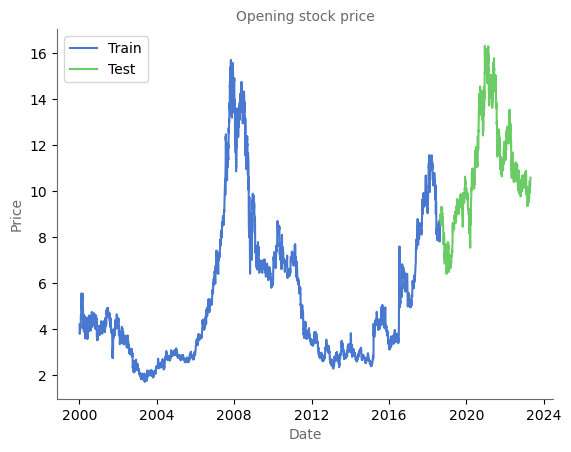

In [10]:
# Create train/test set
train_idx = set(range(round((stock_prices.shape[0]*0.8))))
test_idx = set(range(stock_prices.shape[0]))
test_idx = test_idx - train_idx
train = stock_prices.loc[list(train_idx)].copy()
test = stock_prices.loc[list(test_idx)].copy()

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train['Date'], train['Open'], label='Train');
axes.plot(test['Date'], test['Open'], label='Test');
axes.set_xlabel('Date', color='dimgray');
axes.set_ylabel('Price', color='dimgray');
axes.set_title('Opening stock price', color='dimgray', size=10);
axes.spines[['top', 'right']].set_visible(False);
axes.spines[['left', 'bottom']].set_color('dimgray');
axes.legend();

# Model selection

# Model training & evaluation

# Conclusion